In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from tensorflow.keras import backend as K

In [2]:
def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        for song in os.listdir(genre_folder):
            if song.endswith('.au'):
                signal, sr = librosa.load(os.path.join(genre_folder, song))
                melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                song_specs.append(melspec)
                genres.append(genre_to_idx[genre])
    return song_specs, genres, genre_to_idx, idx_to_genre

song_specs, genres, genre_to_idx, idx_to_genre = load_songs('genres')
song_specs[0].shape

(1280, 128)

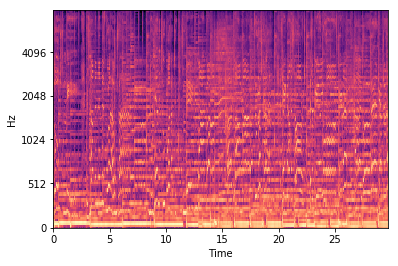

In [3]:
librosa.display.specshow(librosa.power_to_db(song_specs[101].T,
                                              ref=np.max),
                          y_axis='mel', fmax=8000,
                          x_axis='time')

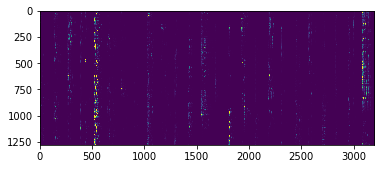

In [4]:
def show_spectogram(show_genre):
    show_genre = genre_to_idx[show_genre]
    specs = []
    for spec, genre in zip(song_specs, genres):
        if show_genre == genre:
            specs.append(spec)
            if len(specs) == 25:
                break
    if not specs:
        return 'not found!'
    x = np.concatenate(specs, axis=1)
    x = (x - x.min()) / (x.max() - x.min())
    plt.imshow((x *20).clip(0, 1.0))

show_spectogram('classical')

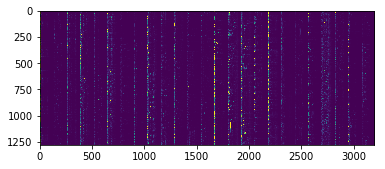

In [5]:
show_spectogram('metal')

In [6]:
def lstm_model(input_shape):
    inputs = Input(shape=input_shape, name='input')
    lstm_1 = LSTM(units=128, return_sequences=False)(inputs)
    
    dense2 = Dense(10, activation='softmax')(lstm_1)

    model = Model(inputs=[inputs], outputs=[dense2])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs
    levels = 64
    
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2
    
    # Global Layers
    x = GlobalMaxPooling1D()(x)

    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    labels = Dense(10, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[labels])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = cnn_model((128, 128))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_v2 (Batc (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 63, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_v

In [7]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)


genres_one_hot = keras.utils.to_categorical(genres, num_classes=len(genre_to_idx))

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot), 
    test_size=0.1, stratify=genres)

x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

x_train.shape, y_train.shape

((9000, 128, 128), (9000, 10))

In [8]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
      min_delta=0,
      patience=3,
      verbose=0,
      mode='auto')

    # Fit the model
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])

Train on 9000 samples, validate on 1000 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
9000/9000 [==============================] - 4s 402us/sample - loss: 3.4189 - acc: 0.1556 - val_loss: 2.2428 - val_acc: 0.2070
Epoch 2/100
9000/9000 [==============================] - 2s 172us/sample - loss: 2.3480 - acc: 0.2134 - val_loss: 2.0823 - val_acc: 0.2610
Epoch 3/100
9000/9000 [==============================] - 2s 170us/sample - loss: 2.1528 - acc: 0.2370 - val_loss: 1.9772 - val_acc: 0.3210
Epoch 4/100
9000/9000 [==============================] - 2s 177us/sample - loss: 2.0717 - acc: 0.2648 - val_loss: 1.9222 - val_acc: 0.3590
Epoch 5/100
9000/9000 [==============================] - 2s 181us/sample - loss: 2.0193 - acc: 0.2806 - val_loss: 1.8757 - val_acc: 0.3800
Epoch 6/100
9000/9000 [==============================] - 2s 181us/sample - loss: 1.9623 - acc: 0.3022 - val_loss: 1.8467 - val_acc:

In [10]:
!mkdir -p zoo/15
model.save('zoo/15/song_classify.h5')

In [11]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.57

In [12]:
cm = confusion_matrix(np.argmax(pred_values, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[62  3  6  8  5  0  4  6  0  5]
 [ 6 25 16 12  2  7  0  4 22  3]
 [ 3  9 23 18  5  3  5  2 13  5]
 [ 5 16  2 27 14  1  0  3  0  0]
 [ 4  1  0 14 68  0  0  8  0  0]
 [ 0  7  6  3  3 81  0  3 18  0]
 [10  5  0  4  0  0 66  9  0 10]
 [ 3  5 11  3  2  0 22 57  0  0]
 [ 0 22 17 11  0  8  0  2 43  3]
 [ 7  7 19  0  1  0  3  6  4 74]]


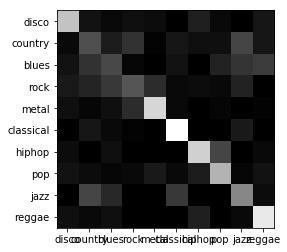

In [13]:
plt.imshow(cm.T, interpolation='nearest', cmap='gray')
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre)
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()

In [14]:
m1 = cnn_melspect_1D_org((128, 128))
m2 = cnn_melspect_1D((128, 128))
ac1 = 0.61 * 5
ac2 = 0
for i in range(5):
    history = m1.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac1 += history.history['val_acc'][-1]
    history = m2.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac2 += history.history['val_acc'][-1]

print(ac1 / 5, ac2 / 5)

NameError: name 'cnn_melspect_1D_org' is not defined